In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
from datetime import datetime

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Plot Each Row ----------
for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    # Get valid indices (not NaN)
    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 4:
        print(f"Skipping row {idx} at (Lat, Lon) = ({lat}, {lon}) due to insufficient data.")
        continue

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    # Convert datetime to days for interpolation
    x = (valid_dates - valid_dates[0]).days
    x_all = (date_times - valid_dates[0]).days

    # Apply cubic spline interpolation
    cs = make_interp_spline(x, valid_values, k=2)  # k=2 for quadratic spline
    interpolated = cs(x_all)


    # Only consider plotting between the first and last valid points
    first_valid_idx = valid_mask.argmax()
    last_valid_idx = len(valid_mask) - np.argmax(valid_mask[::-1])  # index of last True

    plot_dates = date_times[first_valid_idx:last_valid_idx]
    plot_values = interpolated[first_valid_idx:last_valid_idx]

    # Set y-axis limits dynamically per plot
    local_min = np.min(plot_values)
    local_max = np.max(plot_values)
    padding = (local_max - local_min) * 0.1  # 10% padding
    ymin = local_min - padding
    ymax = local_max + padding

    # ---------- Step 3: Plot ----------
    plt.figure(figsize=(14, 5))
    plt.plot(plot_dates, plot_values, label='Cubic Spline', color='blue')
    plt.scatter(valid_dates, valid_values, label='Original Data', color='red')
    plt.title(f'Cubic Spline Interpolation for (Lat: {lat}, Lon: {lon})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.ylim(ymin, ymax)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)

    plt.show()
    # Optional: Save plot
    # plt.savefig(f'spline_plot_{lat}_{lon}.png')


In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Get Metrics ----------
results = []

for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 6:
        continue  # Need at least 6 points for 80/20 split

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    total_points = len(valid_values)
    split_idx = int(total_points * 0.8)

    train_dates = valid_dates[:split_idx]
    train_values = valid_values[:split_idx]
    test_dates = valid_dates[split_idx:]
    test_values = valid_values[split_idx:]

    # Skip if test set is too small
    if len(test_values) < 2:
        continue

    # Convert to days
    x_train = (train_dates - train_dates[0]).days
    x_test = (test_dates - train_dates[0]).days

    try:
        # Fit spline and predict
        spline = make_interp_spline(x_train, train_values, k=2)
        y_pred = spline(x_test)

        # Calculate metrics
        mae = mean_absolute_error(test_values, y_pred)
        rmse = mean_squared_error(test_values, y_pred, squared=False)
        r2 = r2_score(test_values, y_pred)

        results.append({
            'Index': idx,
            'Lat': lat,
            'Lon': lon,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

    except Exception as e:
        print(f"Interpolation failed for row {idx} ({lat}, {lon}): {e}")
        continue

# ---------- Step 3: Save or Display Metrics ----------
results_df = pd.DataFrame(results)
print(results_df)

# Optionally save to CSV
# results_df.to_csv('interpolation_metrics.csv', index=False)


     Index    Lat    Lon         MAE        RMSE             R2
0        0  23.00  74.25   48.773754   66.288202   -1066.302722
1        1  23.00  74.50  120.039162  146.445796   -7344.312208
2        2  23.25  73.75  143.819362  184.769080   -6347.956075
3        3  23.25  74.00    4.782289    6.103711      -9.412418
4        4  23.25  74.25   27.896015   35.337379   -2941.491874
..     ...    ...    ...         ...         ...            ...
918    918  32.00  75.25  175.451003  225.992289  -33739.283115
919    919  32.00  75.50  326.210979  439.298450 -738614.584123
920    920  32.25  75.25    8.972204   11.538161    -191.897313
921    921  32.25  75.50  375.872681  505.358006 -714052.970307
922    922  32.25  75.75    7.993214    8.674506    -394.753877

[923 rows x 6 columns]



Zone-wise Performance Statistics:
                 MAE            RMSE                    R2              
                mean     std    mean     std          mean           std
Zone                                                                    
Central-East  115.27  246.10  149.72  287.22 -4.219649e+04  2.251846e+05
Central-West  107.57  221.27  142.44  294.16 -3.320994e+27  5.047475e+28
North-East    123.94  123.17  165.97  162.91 -5.229542e+04  1.349426e+05
North-West     82.82   92.73  116.24  137.47 -3.546442e+04  5.205448e+04
South-East    190.37  163.62  247.84  211.06 -2.764428e+04  5.074191e+04
South-West    149.12  188.06  194.06  253.09 -7.603450e+03  1.235970e+04


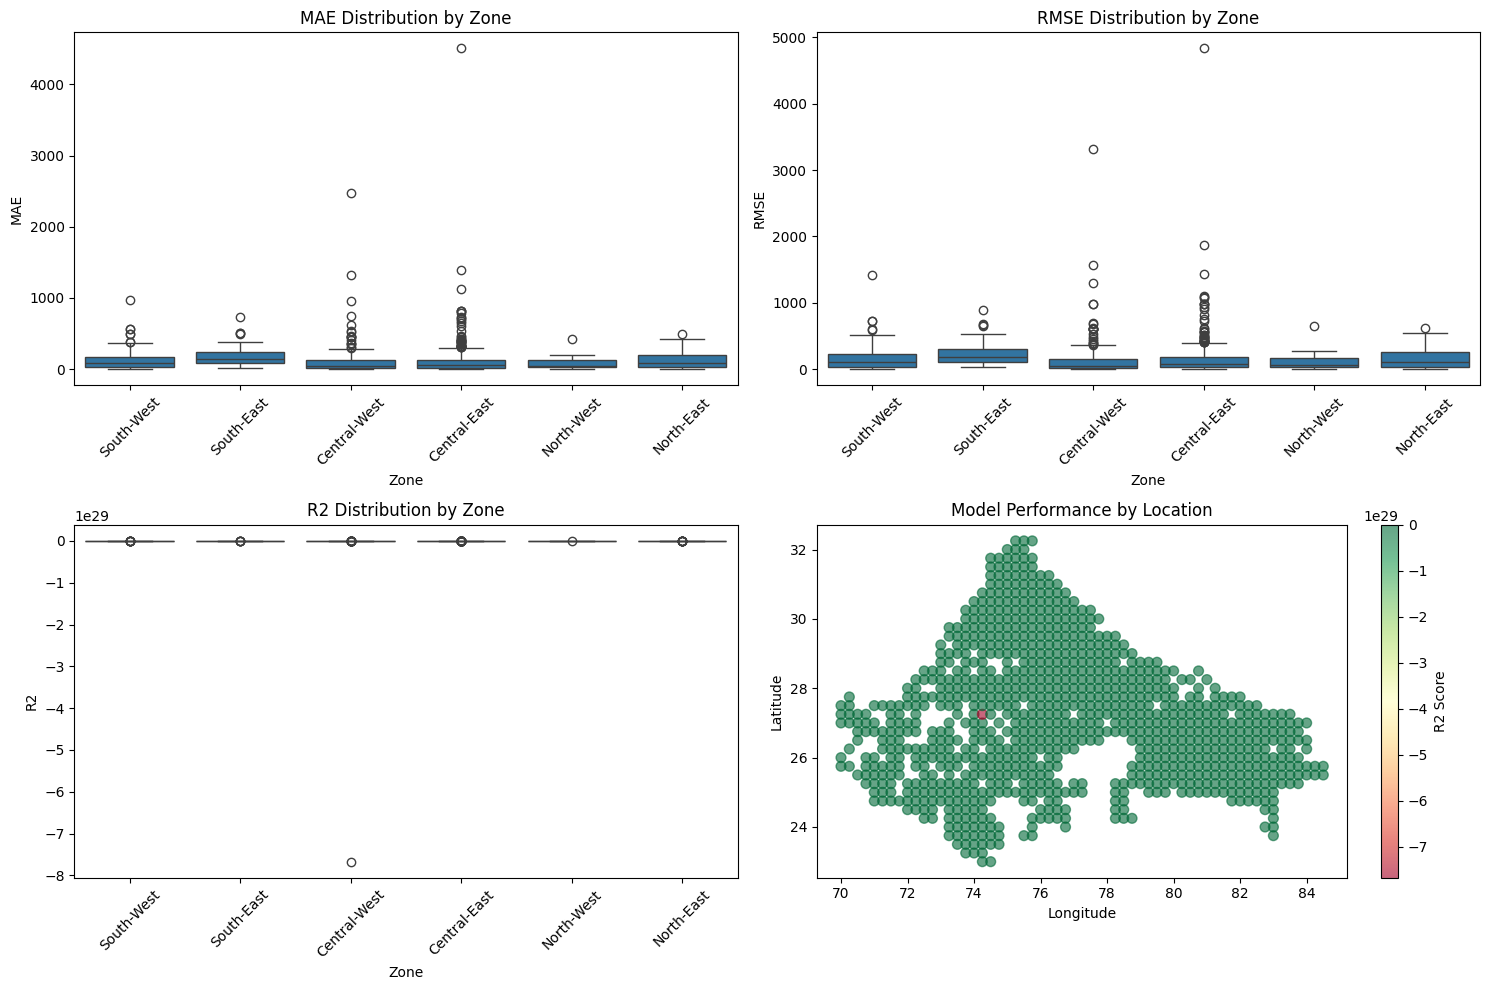


Best Performing Zones (based on R2):
Zone
South-West    -7603.452266
South-East   -27644.282879
North-West   -35464.421145
Name: R2, dtype: float64

Worst Performing Zones (based on R2):
Zone
Central-West   -3.320994e+27
North-East     -5.229542e+04
Central-East   -4.219649e+04
Name: R2, dtype: float64

Number of locations in each zone:
Zone
Central-East    507
Central-West    231
North-East       67
South-West       57
South-East       36
North-West       25
Name: count, dtype: int64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from previous analysis
results_df = pd.DataFrame(results)

# Define zones based on latitude and longitude ranges
def assign_zone(lat, lon):
    if lat < 25:
        if lon < 75:
            return 'South-West'
        else:
            return 'South-East'
    elif lat < 30:
        if lon < 75:
            return 'Central-West'
        else:
            return 'Central-East'
    else:
        if lon < 75:
            return 'North-West'
        else:
            return 'North-East'

# Add zone column to results
results_df['Zone'] = results_df.apply(lambda x: assign_zone(x['Lat'], x['Lon']), axis=1)

# Calculate zone-wise statistics
zone_stats = results_df.groupby('Zone').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(2)

print("\nZone-wise Performance Statistics:")
print(zone_stats)

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Zone-wise MAE Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(x='Zone', y='MAE', data=results_df)
plt.title('MAE Distribution by Zone')
plt.xticks(rotation=45)

# 2. Zone-wise RMSE Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(x='Zone', y='RMSE', data=results_df)
plt.title('RMSE Distribution by Zone')
plt.xticks(rotation=45)

# 3. Zone-wise R2 Box Plot
plt.subplot(2, 2, 3)
sns.boxplot(x='Zone', y='R2', data=results_df)
plt.title('R2 Distribution by Zone')
plt.xticks(rotation=45)

# 4. Scatter plot of locations colored by R2 score
plt.subplot(2, 2, 4)
scatter = plt.scatter(results_df['Lon'], results_df['Lat'], 
                     c=results_df['R2'], cmap='RdYlGn',
                     s=50, alpha=0.6)
plt.colorbar(scatter, label='R2 Score')
plt.title('Model Performance by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print summary of best and worst performing zones
print("\nBest Performing Zones (based on R2):")
best_zones = results_df.groupby('Zone')['R2'].mean().sort_values(ascending=False)
print(best_zones.head(3))

print("\nWorst Performing Zones (based on R2):")
worst_zones = results_df.groupby('Zone')['R2'].mean().sort_values()
print(worst_zones.head(3))

# Additional analysis: Count of locations in each zone
zone_counts = results_df['Zone'].value_counts()
print("\nNumber of locations in each zone:")
print(zone_counts)


📊 Zone-wise Performance Statistics:
            MAE              RMSE                     R2              
           mean      std     mean      std          mean           std
Zone                                                                  
Zone-1  105.538   98.959  138.957  131.807 -2.055871e+04  3.461817e+04
Zone-2   84.576  129.668  114.283  180.713 -5.479641e+27  6.483599e+28
Zone-3  150.095  281.776  194.151  370.812 -1.048421e+04  3.208179e+04
Zone-4  118.243  370.967  148.900  415.454 -5.244930e+04  1.870082e+05
Zone-5  105.615  129.800  142.769  174.871 -8.236777e+04  3.870173e+05
Zone-6  166.290  203.703  218.247  270.856 -6.362456e+04  4.145972e+05


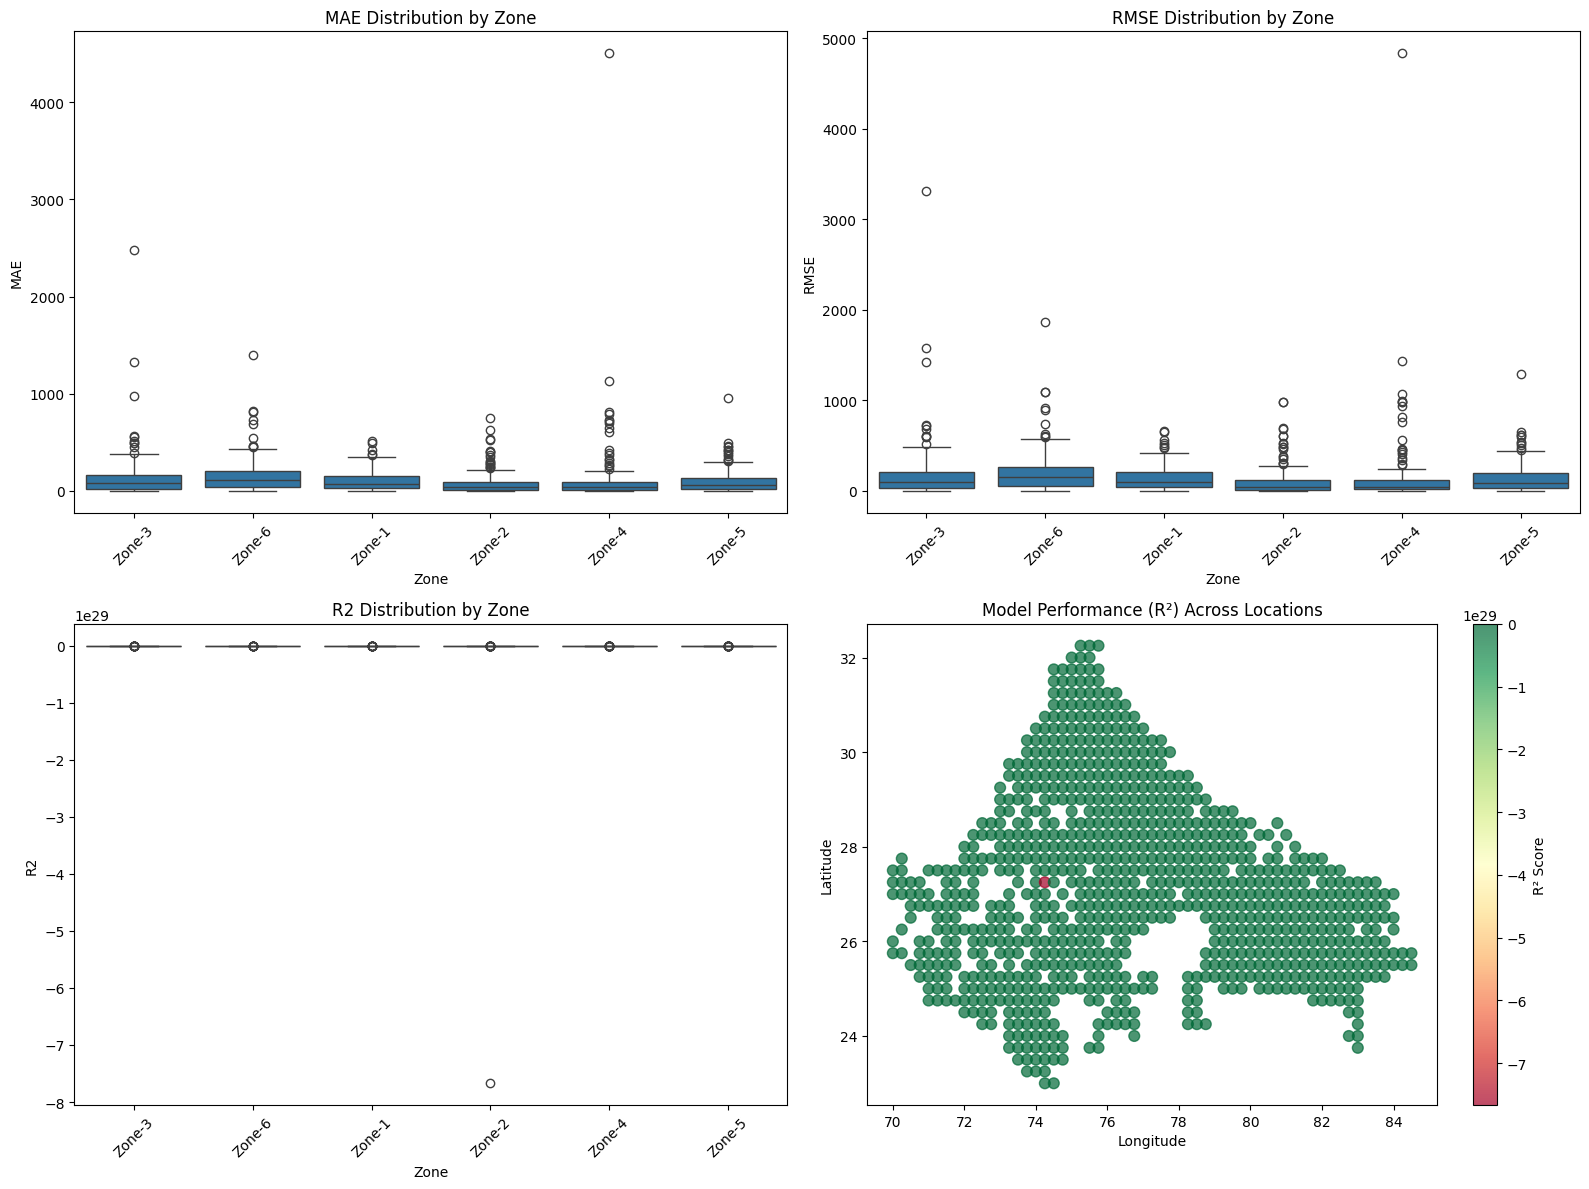


🏆 Top Performing Zones (by mean R²):
Zone
Zone-3   -10484.210809
Zone-1   -20558.705461
Zone-4   -52449.298874
Name: R2, dtype: float64

⚠️ Lowest Performing Zones (by mean R²):
Zone
Zone-2   -5.479641e+27
Zone-5   -8.236778e+04
Zone-6   -6.362456e+04
Name: R2, dtype: float64

📍 Data Points per Zone:
Zone
Zone-1    212
Zone-4    178
Zone-5    158
Zone-2    140
Zone-3    124
Zone-6    111
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -------------------- Load Results --------------------
results_df = pd.DataFrame(results)  # from your earlier CubicSpline model

# -------------------- Dynamic Zoning via KMeans --------------------
# Choose number of zones (clusters)
n_zones = 6  # Change this to 4, 6, 8... depending on how granular you want

# Standardize Lat & Lon for clustering
scaler = StandardScaler()
coords = scaler.fit_transform(results_df[['Lat', 'Lon']])

# KMeans Clustering
kmeans = KMeans(n_clusters=n_zones, random_state=42)
zone_labels = kmeans.fit_predict(coords)

# Add cluster labels to DataFrame as 'Zone'
results_df['Zone'] = ['Zone-' + str(i+1) for i in zone_labels]

# -------------------- Zone-wise Statistics --------------------
zone_stats = results_df.groupby('Zone').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(3)

print("\n📊 Zone-wise Performance Statistics:")
print(zone_stats)

# -------------------- Visualizations --------------------
plt.figure(figsize=(16, 12))

# 1. MAE Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(x='Zone', y='MAE', data=results_df)
plt.title('MAE Distribution by Zone')
plt.xticks(rotation=45)

# 2. RMSE Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(x='Zone', y='RMSE', data=results_df)
plt.title('RMSE Distribution by Zone')
plt.xticks(rotation=45)

# 3. R2 Box Plot
plt.subplot(2, 2, 3)
sns.boxplot(x='Zone', y='R2', data=results_df)
plt.title('R2 Distribution by Zone')
plt.xticks(rotation=45)

# 4. R2 vs Location (Map View)
plt.subplot(2, 2, 4)
scatter = plt.scatter(results_df['Lon'], results_df['Lat'], 
                      c=results_df['R2'], cmap='RdYlGn', s=60, alpha=0.7)
plt.colorbar(scatter, label='R² Score')
plt.title('Model Performance (R²) Across Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# -------------------- Summary --------------------
print("\n🏆 Top Performing Zones (by mean R²):")
print(results_df.groupby('Zone')['R2'].mean().sort_values(ascending=False).head(3))

print("\n⚠️ Lowest Performing Zones (by mean R²):")
print(results_df.groupby('Zone')['R2'].mean().sort_values().head(3))

print("\n📍 Data Points per Zone:")
print(results_df['Zone'].value_counts())
